In [55]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\akili\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load the dataset

In [75]:

#df = pd.read_csv("raw_analyst_ratings.csv")
file_path = "../data/raw_analyst_ratings.csv"
df= pd.read_csv(file_path)
df

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX


Column names and data types

In [14]:
print("Column names and data types:")
print(df.dtypes)

Column names and data types:
Unnamed: 0          int64
headline           object
url                object
publisher          object
date               object
stock              object
headline_length     int64
dtype: object


In [15]:
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))
 
int_ = (df.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))
 
fl = (df.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 5
Integer variables: 0
Float variables: 0


1. Descriptive Statistics:

In [17]:
# Descriptive Statistics
## Obtain basic statistics for textual lengths
print("\nDescriptive statistics for for textual lengths:")
df['headline_length'] = df['headline'].apply(len)
print(df['headline_length'].describe())


Descriptive statistics for for textual lengths:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


statistics for the length of news article headlines

In [18]:

df['headline_length'] = df['headline'].apply(len)

# Basic statistics
mean_length = df['headline_length'].mean()
median_length = df['headline_length'].median()
std_dev = df['headline_length'].std()
range_min = df['headline_length'].min()
range_max = df['headline_length'].max()

print(f"Mean headline length: {mean_length:.2f} characters")
print(f"Median headline length: {median_length:.2f} characters")
print(f"Standard deviation: {std_dev:.2f}")
print(f"Range: {range_min} - {range_max} characters")

Mean headline length: 73.12 characters
Median headline length: 64.00 characters
Standard deviation: 40.74
Range: 3 - 512 characters


count the number of articles published by each news outlet:

In [22]:
## Count the number of articles per publisher
article_counts = df['publisher'].value_counts()
print("Articles per publisher:")
print(article_counts)

Articles per publisher:
publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


Publication Dates Trends:

In [39]:
## Analyze the publication dates
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
day_counts = df['day_of_week'].value_counts()

print(day_counts)

day_of_week
Thursday     302619
Wednesday    300922
Tuesday      296505
Monday       265139
Friday       217918
Sunday        16466
Saturday       7759
Name: count, dtype: int64


Extract relevant components like year, month, day, and day of the week:

In [43]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

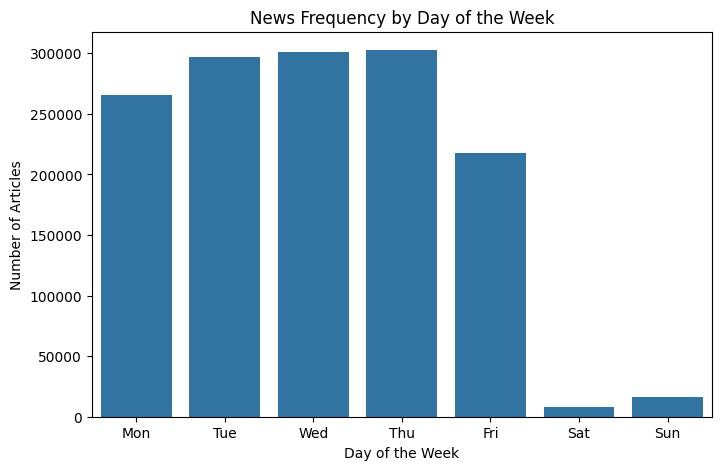

In [45]:
day_counts = df.groupby('day_of_week')['headline'].count()

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.title('News Frequency by Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

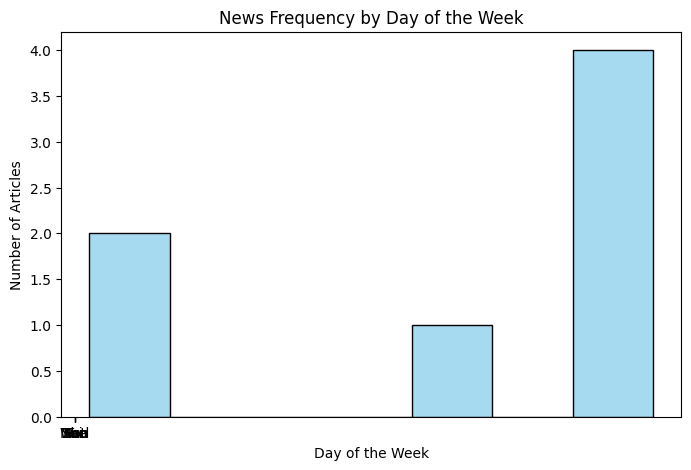

In [46]:


# Group by day of the week and count articles
day_counts = df.groupby('day_of_week')['headline'].count()

# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(day_counts, bins=7, kde=False, color='skyblue', edgecolor='black')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.title('News Frequency by Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


2. Text Analysis:

Sentiment Analysis:

In [56]:
# Text Analysis
## Perform sentiment analysis on headlines

sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiment
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Count sentiment categories
sentiment_counts = df['sentiment_category'].value_counts()
print("Sentiment distribution:")
print(sentiment_counts)




Sentiment distribution:
sentiment_category
Neutral     731893
Positive    448740
Negative    226695
Name: count, dtype: int64


Topic Modeling:

In [66]:
## Identify common keywords or phrases
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['headline'])
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'frequency': np.asarray(X.sum(axis=0)).ravel().tolist()})
print(word_freq.nlargest(columns='frequency', n=10))

            word  frequency
104259        vs     162099
93662     stocks     161776
40857        est     140604
40388        eps     128897
63981     market     120558
89240     shares     114313
83568    reports     108710
101800    update      91723
37999   earnings      87399
86676      sales      79645


3,Time series Analysis:

<Axes: xlabel='date'>

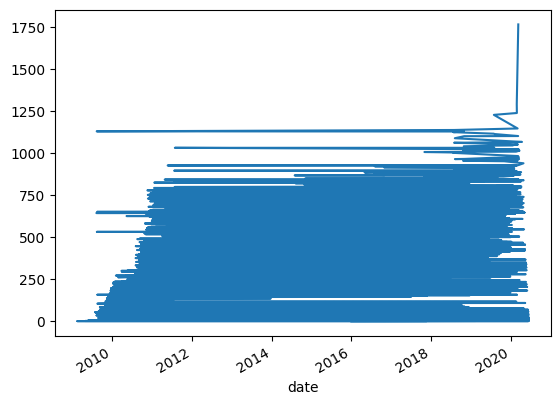

In [67]:
## Publication frequency over time
df['date'].value_counts().plot(kind='line')


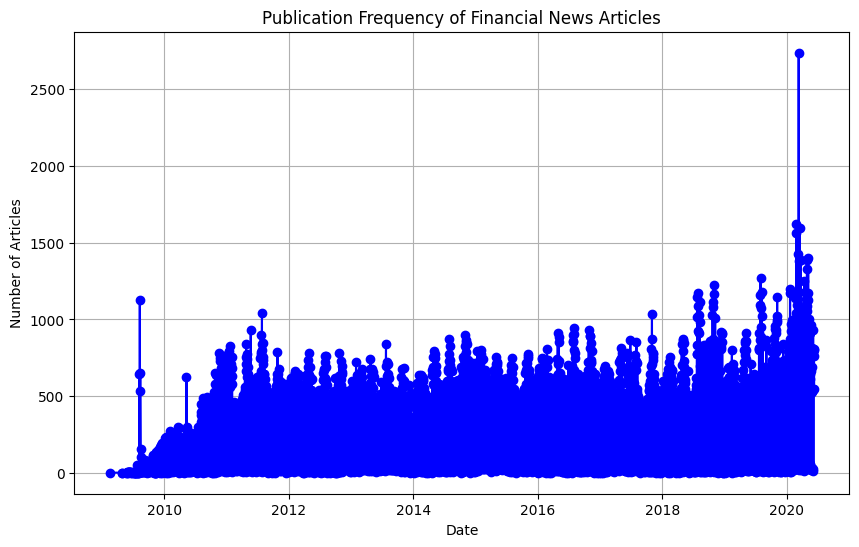

In [71]:

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group articles by date and count the number of publications
daily_publications = df.groupby(df['date'].dt.date)['headline'].count()

# Plot the publication frequency over time
plt.figure(figsize=(10, 6))
daily_publications.plot(kind='line', marker='o', color='b')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Publication Frequency of Financial News Articles')
plt.grid(True)
plt.show()


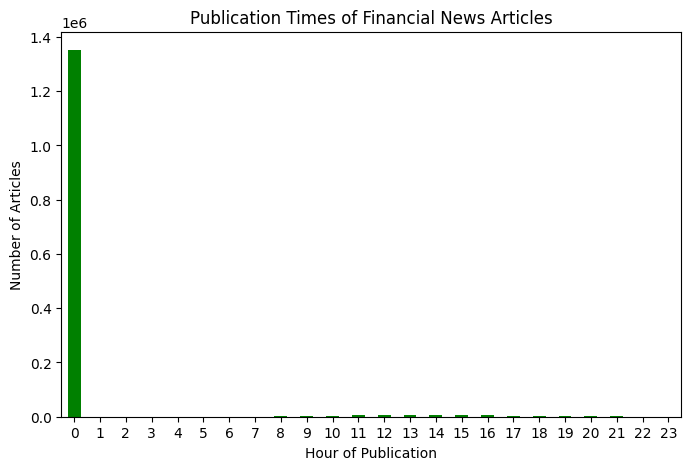

In [72]:
# Extract the hour of publication
df['hour_of_publication'] = df['date'].dt.hour

# Group articles by hour and count the number of publications
hourly_publications = df.groupby('hour_of_publication')['headline'].count()

# Plot the results
plt.figure(figsize=(8, 5))
hourly_publications.plot(kind='bar', color='g')
plt.xlabel('Hour of Publication')
plt.ylabel('Number of Articles')
plt.title('Publication Times of Financial News Articles')
plt.xticks(rotation=0)
plt.show()


In [68]:
## Analysis of publishing times
df['hour'] = df['date'].dt.hour
hour_counts = df['hour'].value_counts()
print(hour_counts)

hour
0     1351472
14       7669
13       5965
16       5732
15       5701
12       5527
11       5033
20       3939
21       2800
17       2710
10       2476
18       2075
9        1829
19       1612
8        1469
22        704
23        227
7          93
1          82
4          67
6          57
2          48
3          27
5          14
Name: count, dtype: int64


# Publisher Analysis


In [73]:

# Extract unique domains from email addresses (if applicable)
df['publisher_domain'] = df['publisher'].str.split('@').str[-1]

# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()

# Print top publishers and their article counts
print("Top Publishers:")
print(publisher_counts.head(10))

# Print unique publisher domains (if applicable)
unique_domains = df['publisher_domain'].nunique()
print(f"Unique Publisher Domains: {unique_domains}")


Top Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64
Unique Publisher Domains: 1024


In [69]:
## Which publishers contribute most to the news feed
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)


publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


In [70]:
## Identify unique domains if email addresses are used as publisher names
df['email_domain'] = df['publisher'].apply(lambda x: x.split('@')[1] if '@' in x else np.nan)
domain_counts = df['email_domain'].value_counts()
print(domain_counts)


email_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


correlation between sentiment and stock price changes